## Random Forest in predictive maintenance

### Read dataset

In [ ]:
import pandas as pd
data = pd.read_csv("./sensor.csv")

### Data pre-processing

#### Drop invalid data

In [ ]:
data.drop(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_15','sensor_50', 'sensor_51'], axis=1, inplace=True)

In [ ]:
import numpy as np
conditions = [(data['machine_status'] == 'NORMAL'), (data['machine_status'] == 'BROKEN'), (data['machine_status'] == 'RECOVERING')]
choices = [1, 0, 0.5]
# create new column "Operation"
data['Operation'] = np.select(conditions,choices, default=0)

In [ ]:
df = pd.DataFrame(data, columns=['Operation','sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09'])

#### Convert time series to supervised

In [41]:
"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

#### Data scaling

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu về đoạn [0,1]
values = df.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
scaled
# reframed = series_to_supervised(scaled,1,1)
# r = list(range(df.shape[1]+1, 2*df.shape[1]))
# reframed.drop(reframed.columns[r], axis=1, inplace=True)
# reframed.head()

array([[1.        , 0.79224211, 0.60247235, 0.68362953, 0.63890538,
        0.6021412 ],
       [1.        , 0.79224211, 0.60247235, 0.68362953, 0.63890538,
        0.6021412 ],
       [1.        , 0.79790429, 0.59856845, 0.67964464, 0.64098762,
        0.6004052 ],
       ...,
       [1.        , 0.78164367, 0.67794401, 0.70784824, 0.64425941,
        0.6047452 ],
       [1.        , 0.79383907, 0.67924501, 0.70202325, 0.64604395,
        0.6047452 ],
       [1.        , 0.79906572, 0.67924501, 0.70570217, 0.64247446,
        0.6004052 ]])

In [43]:
reframed = series_to_supervised(scaled,1,1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
0,1.0,0.792242,0.602472,0.683630,0.638905,0.602141,1.0
1,1.0,0.797904,0.598568,0.679645,0.640988,0.600405,1.0
2,1.0,0.784402,0.598243,0.688535,0.644259,0.603299,1.0
3,1.0,0.794855,0.599870,0.687002,0.644259,0.603299,1.0
4,1.0,0.796307,0.602472,0.685162,0.652290,0.606482,1.0


#### Split dataset to train and test

In [44]:
values = reframed.values
n_train_time = 50000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]   # train_x: n-1 cột đầu tiên, train_y: cột cuối cùng (operation)
test_x, test_y = test[:, :-1], test[:, -1]

### Build model

#### Build and fit model

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [25, 50, 100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
grid_search = GridSearchCV(RandomForestRegressor(),
                           param_grid=param_grid)
grid_search.fit(train_x,train_y)
print(grid_search.best_estimator_)

RandomForestRegressor(max_depth=3, max_features=None, max_leaf_nodes=9,
                      n_estimators=150)


### Fit model with best params

In [45]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(max_depth=3,max_leaf_nodes=9,n_estimators=150)
regressor.fit(train_x,train_y)

RandomForestRegressor(max_depth=3, max_leaf_nodes=9, n_estimators=150)

#### Predict

In [46]:
predict_y = regressor.predict(test_x)

In [47]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score

size = df.shape[1]

yhat = predict_y.reshape(predict_y.shape[0],1)
test_x = test_x.reshape(test_x.shape[0], size)

# invert scalling
inv_yhat = np.concatenate((yhat, test_x[:,1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape(len(test_y), 1)
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# caculate RSME
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RSME: %.3f' % rmse)


Test RSME: 0.004


### Evaluate

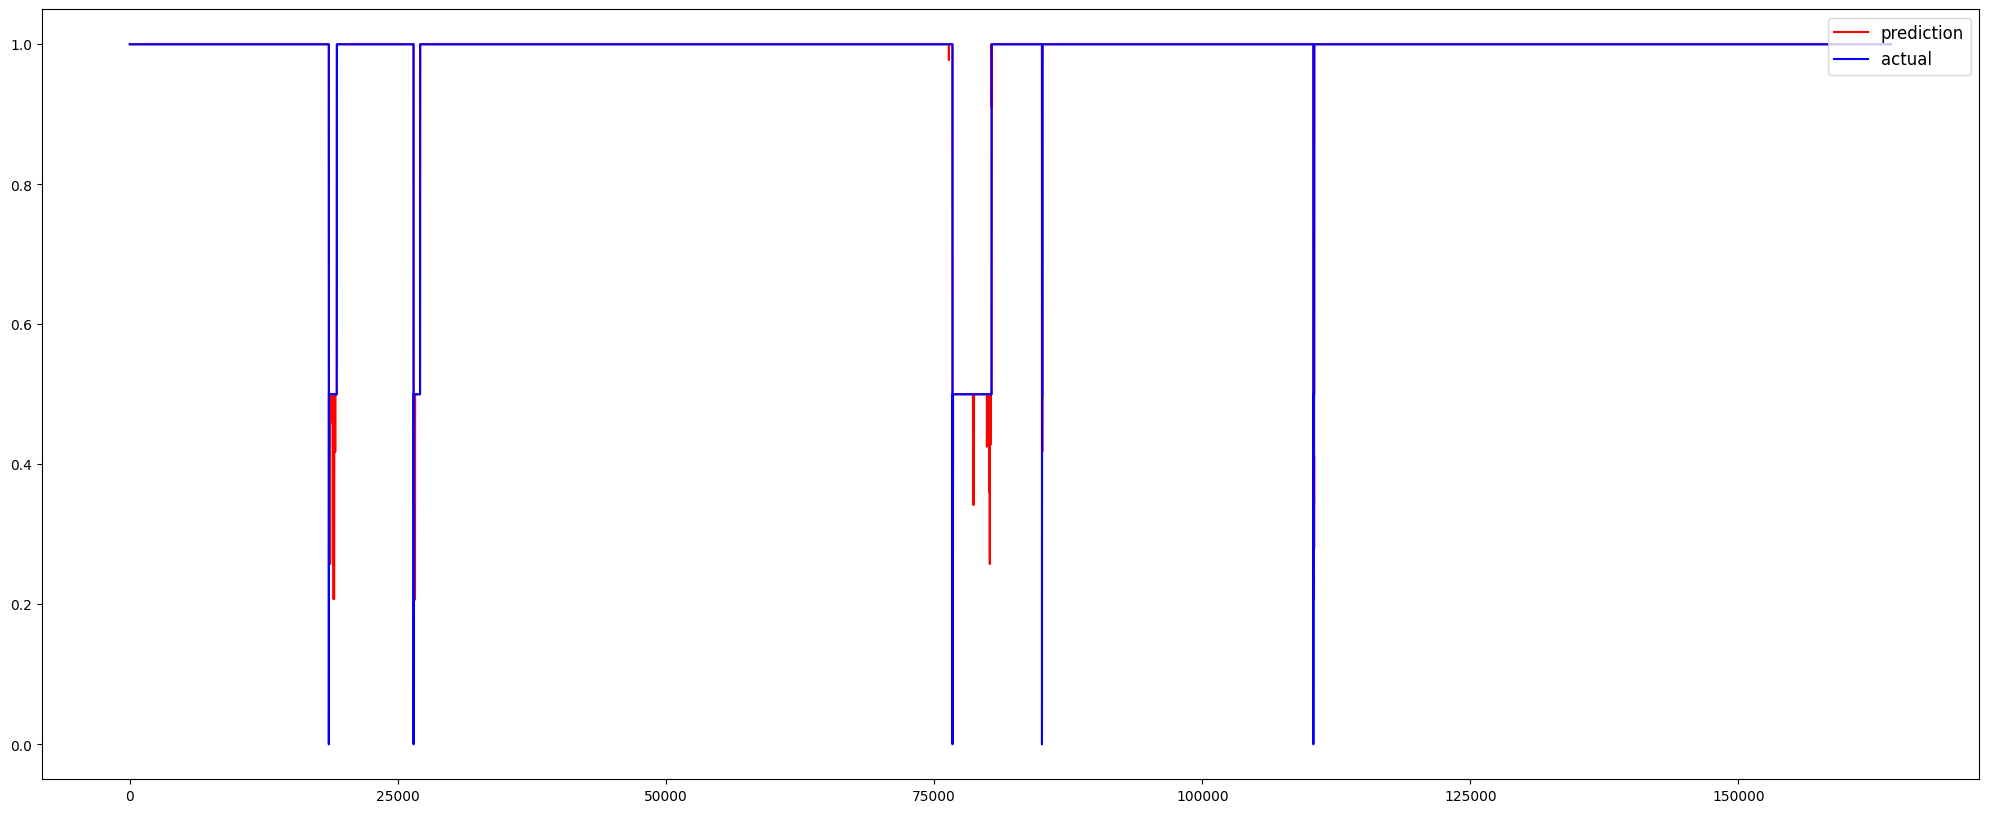

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(25,10))
plt.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='prediction')
plt.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
plt.legend(loc=1, prop={'size': 12})
plt.show()